# Radiomics Feature Extraction

Extracting features from PET and CT images.

In [1]:
import os
import nrrd
import utils 
import radiomics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from feature_extraction import feature_extractor

%matplotlib inline

In [2]:
path_masksdir = './../../../data_source/images/masks_nrrd/'
path_reseg_mask = './../../../data_source/images/masks_resegm_nrrd/'
path_ct_imagedir = './../../../data_source/images/ct_anomaly_filtered_nrrd/'
path_pet_imagedir = './../../../data_source/images/pet_anomaly_filtered_nrrd/'

In [3]:
paths_ct_images = utils.sample_paths(
    path_ct_imagedir, path_masksdir, target_format='nrrd'
)
paths_pet_images = utils.sample_paths(
    path_pet_imagedir, path_masksdir, target_format='nrrd'
)

## Setup

In [4]:
def z_score_transform(image, n=None):
    # Texture features is shown to be more stable after GL normalizations.
    # Ref: Voxel size and gray level normalization of CT radiomic features 
    #      in lung cancer.
    _image = np.copy(image)
    
    # Z-score transformation.
    image_std = np.std(_image)
    image_zscore = (_image - np.mean(_image)) / image_std
    
    # Remove outliers.
    if n is not None:
        outliers = n * image_std 
        image_zscore = np.clip(image_zscore, -1.0 * outliers, outliers)

    return image_zscore


def bin_widths(path_images, nbins, n=3, z_scoring=False, outlier_removal=None):
    """Average min and max to compare histogram across stacks.
    Fixed bin iwdth (and not fixed bin size) to compare texture
    features across stacks.
    
    """
    img_max, img_min = [], []
    for image_path in path_images:
        image, _ = nrrd.read(image_path['Image'])
        
        if z_scoring:
            image = z_score_transform(image, n=outlier_removal)
        
        img_max.append(np.ceil(np.max(image)))
        img_min.append(np.floor(np.min(image)))
  
    return (np.mean(img_max) - np.mean(img_min)) / nbins

In [ ]:
bin_widths(paths_ct_images, 32), bin_widths(paths_ct_images, 64), bin_widths(paths_ct_images, 128)

In [ ]:
bin_widths(paths_pet_images, 32), bin_widths(paths_pet_images, 64), bin_widths(paths_pet_images, 128)

In [ ]:
print(bin_widths(paths_ct_images, 32, z_scoring=True, outlier_removal=3))
print(bin_widths(paths_ct_images, 64, z_scoring=True, outlier_removal=3))
print(bin_widths(paths_ct_images, 128, z_scoring=True, outlier_removal=3))

## Mask resegmentation

In [5]:
def threshold(image, mask, thresh=None):
    # REF: 
    # * Effects of CT threshold value to make a surface bone model 
    #   on accuracy of shape-based registration in a CT-based navigation 
    #   system for hip surgery.
    
    _mask = np.copy(mask)
    _mask[np.where(image > thresh)] = 0
    
    return _mask

In [6]:
img1, _ = nrrd.read('./../../../data_source/images/ct_cropped_nrrd/P088CT.nrrd')
img2, _ = nrrd.read('./../../../data_source/images/ct_cropped_nrrd/P082CT.nrrd')
img3, _ = nrrd.read('./../../../data_source/images/ct_cropped_nrrd/P117CT.nrrd')

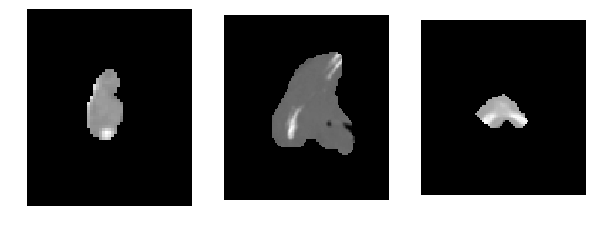

In [7]:
images = [img1[:, :, 30], img2[:, :, 50], img3[:, :, 20]]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
for num, axis in enumerate(axes.ravel()):
    image = np.copy(images[num])
    axis.imshow(image, cmap=plt.cm.gray)
    axis.axis('off')

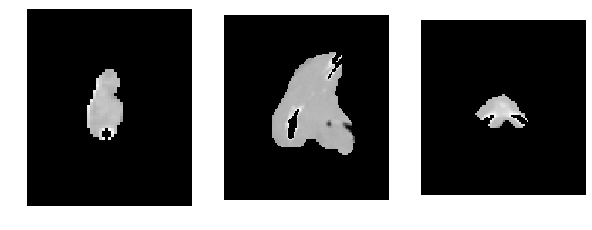

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
for num, axis in enumerate(axes.ravel()):
    image = np.copy(images[num])
    image[images[num] > 1500] = 0
    axis.imshow(image, cmap=plt.cm.gray)
    axis.axis('off')

In [9]:
base_thresh_mask = './../../../data_source/images/masks_resegm_nrrd/'
for image_path in paths_ct_images:
    image, _ = nrrd.read(image_path['Image'])
    mask, _ = nrrd.read(image_path['Mask'])

    mask_thresh = threshold(image, mask, thresh=1500)
    mask_thresh_path = os.path.join(base_thresh_mask, image_path['Image'].split('/')[-1])

    nrrd.write(mask_thresh_path, mask_thresh)

In [10]:
# Update file paths to re-segmented masks.
paths_ct_images = utils.sample_paths(
    path_ct_imagedir, base_thresh_mask, target_format='nrrd'
)
paths_pet_images = utils.sample_paths(
    path_pet_imagedir, base_thresh_mask, target_format='nrrd'
)

## Calculate features

In [20]:
ct_param_files = [
    #'./parameter_files/shape/shape_config.yaml',
    #'./parameter_files/firstorder/ct32_firstorder_no_filter_config.yaml',
    #'./parameter_files/firstorder/ct64_firstorder_no_filter_config.yaml',
    #'./parameter_files/firstorder/ct128_firstorder_no_filter_config.yaml'
    './parameter_files/texture/ct32_texture_no_filter_config.yaml',
    './parameter_files/texture/ct64_texture_no_filter_config.yaml',
    './parameter_files/texture/ct128_texture_no_filter_config.yaml',
]
ct_feature_files = [
    #'./../../../data_source/radiomic_features/shape/shape_features.csv',
    #'./../../../data_source/radiomic_features/firstorder/ct32_firstorder_no_filter_config.csv',
    #'./../../../data_source/radiomic_features/firstorder/ct64_firstorder_no_filter_config.csv',
    #'./../../../data_source/radiomic_features/firstorder/ct128_firstorder_no_filter_config.csv'
    './../../../data_source/radiomic_features/texture/ct32_texture_no_filter_config.csv',
    './../../../data_source/radiomic_features/texture/ct64_texture_no_filter_config.csv',
    './../../../data_source/radiomic_features/texture/ct128_texture_no_filter_config.csv',
]
for ct_param_file, ct_feature_file in zip(ct_param_files, ct_feature_files):
    feature_extractor(
        ct_param_file,
        paths_ct_images, 
        verbose=1, 
        path_to_results=ct_feature_file
    )

Initiated feature extraction.


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    4.9s
[Parallel(n_jobs=3)]: Done 195 out of 195 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initiated feature extraction.


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    5.7s
[Parallel(n_jobs=3)]: Done 195 out of 195 | elapsed:   22.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initiated feature extraction.


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    5.7s
[Parallel(n_jobs=3)]: Done 195 out of 195 | elapsed:   22.0s finished


In [22]:
pet_param_files = [
    #'./parameter_files/firstorder/pet32_firstorder_no_filter_config.yaml',
    #'./parameter_files/firstorder/pet64_firstorder_no_filter_config.yaml',
    #'./parameter_files/firstorder/pet128_firstorder_no_filter_config.yaml'
    './parameter_files/texture/pet32_texture_no_filter_config.yaml',
    './parameter_files/texture/pet64_texture_no_filter_config.yaml',
    './parameter_files/texture/pet128_texture_no_filter_config.yaml',
]
pet_feature_files = [
    #'./../../../data_source/radiomic_features/firstorder/pet32_firstorder_no_filter_config.csv',
    #'./../../../data_source/radiomic_features/firstorder/pet64_firstorder_no_filter_config.csv',
    #'./../../../data_source/radiomic_features/firstorder/pet128_firstorder_no_filter_config.csv'
    './../../../data_source/radiomic_features/texture/pet32_texture_no_filter_config.csv',
    './../../../data_source/radiomic_features/texture/pet64_texture_no_filter_config.csv',
    './../../../data_source/radiomic_features/texture/pet128_texture_no_filter_config.csv',
]
for pet_param_file, pet_feature_file in zip(pet_param_files, pet_feature_files):
    feature_extractor(
        pet_param_file,
        paths_pet_images, 
        verbose=1, 
        path_to_results=pet_feature_file
    )

Initiated feature extraction.


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 195 out of 195 | elapsed:   20.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initiated feature extraction.


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    5.4s
[Parallel(n_jobs=3)]: Done 195 out of 195 | elapsed:   23.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initiated feature extraction.


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.6s
[Parallel(n_jobs=3)]: Done 195 out of 195 | elapsed:   28.5s finished
